In [35]:
import sys
import os

import cv2
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.metrics import categorical_accuracy

project_path = os.path.abspath(os.path.join('../'))
if project_path not in sys.path:
    sys.path.append(project_path)
from utils.load_data import load_FER2013, parse_FER2013, load_CKPlus
from utils.plots import plot_face_with_label, plot_model_history, plot_generated_images
from models.model import create_model, mini_Xception
from utils.data_generator import initialize_generator

checkpoint_path = '../models/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [36]:
# Constants
DATA_DIR = '../data'
possible_emotions = ['anger', 'disgust', 'fear', 'happiness',
                    'sadness', 'surprise', 'neutral']
emotion_label_map = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3,
                    'sadness': 4, 'surprise': 5, 'neutral': 6}

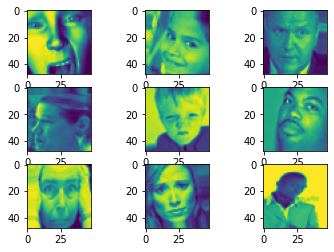

In [37]:
train_FER, val_FER, test_FER = load_FER2013(DATA_DIR)
x_train_FER, y_train_FER = parse_FER2013(train_FER)
x_val_FER, y_val_FER = parse_FER2013(val_FER)
x_test_FER, y_test_FER = parse_FER2013(test_FER)
x_CK, y_CK = load_CKPlus(DATA_DIR, emotion_label_map)

train_gen = initialize_generator(x_train_FER)
plot_generated_images(train_gen, x_train_FER)

In [38]:
fer_model = mini_Xception()
fer_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 46, 46, 8)    72          input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 46, 46, 8)    32          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 46, 46, 8)    0           batch_normalization_42[0][0]     
____________________________________________________________________________________________

In [39]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, , verbose=1)
history = fer_model.fit(train_gen.flow(x_train_FER, y_train_FER, batch_size=32),
                    epochs=50, batch_size=32,
                    validation_data=(x_val_FER/255.0, y_val_FER),
                    callbacks=[cp_callback])

Epoch 1/50
898/898 [==============================] - 63s 69ms/step - loss: 1.8887 - accuracy: 0.2891 - val_loss: 1.6860 - val_accuracy: 0.3798

Epoch 00001: saving model to ../models/cp.ckpt
Epoch 2/50
898/898 [==============================] - 66s 73ms/step - loss: 1.5574 - accuracy: 0.4234 - val_loss: 1.5204 - val_accuracy: 0.4536

Epoch 00002: saving model to ../models/cp.ckpt
Epoch 3/50
898/898 [==============================] - 65s 72ms/step - loss: 1.4245 - accuracy: 0.4634 - val_loss: 1.4529 - val_accuracy: 0.4639

Epoch 00003: saving model to ../models/cp.ckpt
Epoch 4/50
898/898 [==============================] - 65s 73ms/step - loss: 1.3498 - accuracy: 0.4965 - val_loss: 1.3234 - val_accuracy: 0.5096

Epoch 00004: saving model to ../models/cp.ckpt
Epoch 5/50
898/898 [==============================] - 65s 73ms/step - loss: 1.3051 - accuracy: 0.5128 - val_loss: 1.2916 - val_accuracy: 0.5263

Epoch 00005: saving model to ../models/cp.ckpt
Epoch 6/50
898/898 [====================

898/898 [==============================] - 67s 75ms/step - loss: 0.9732 - accuracy: 0.6364 - val_loss: 1.0908 - val_accuracy: 0.6016

Epoch 00043: saving model to ../models/cp.ckpt
Epoch 44/50
898/898 [==============================] - 65s 73ms/step - loss: 0.9602 - accuracy: 0.6416 - val_loss: 1.0890 - val_accuracy: 0.6085

Epoch 00044: saving model to ../models/cp.ckpt
Epoch 45/50
898/898 [==============================] - 66s 74ms/step - loss: 0.9642 - accuracy: 0.6379 - val_loss: 1.1131 - val_accuracy: 0.5985

Epoch 00045: saving model to ../models/cp.ckpt
Epoch 46/50
898/898 [==============================] - 66s 73ms/step - loss: 0.9568 - accuracy: 0.6450 - val_loss: 1.1093 - val_accuracy: 0.5991

Epoch 00046: saving model to ../models/cp.ckpt
Epoch 47/50
898/898 [==============================] - 67s 74ms/step - loss: 0.9660 - accuracy: 0.6401 - val_loss: 1.1304 - val_accuracy: 0.5999

Epoch 00047: saving model to ../models/cp.ckpt
Epoch 48/50
898/898 [==========================

In [42]:
test_preds = fer_model.predict(x_test_FER/255).argmax(axis=1)
acc = (test_preds == np.argmax(y_test_FER, axis=1)).mean()
loss, acc = fer_model.evaluate(x_test_FER/255, y_test_FER)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

113/113 [==============================] - 1s 12ms/step - loss: 1.0426 - accuracy: 0.6147
Restored model, accuracy: 61.47%


In [43]:
fer_model.save('../models/')
fer_model.save('../saved_models/mini_Xception-0.61.h5')


INFO:tensorflow:Assets written to: ../models/assets


In [44]:
m = keras.models.load_model('../saved_models/mini_Xception-0.61.h5')

29/29 [==============================] - 0s 13ms/step - loss: 0.8652 - accuracy: 0.6926


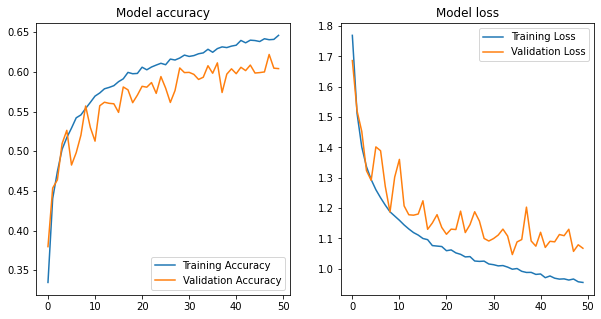

In [58]:
plot_model_history(range(50), history.history)
loss, acc = m.evaluate(x_CK/255, y_CK)


array([[11.464529  ,  7.106337  ,  3.3582973 , 19.778044  , 27.595377  ,
         0.33463994, 30.362774  ]], dtype=float32)

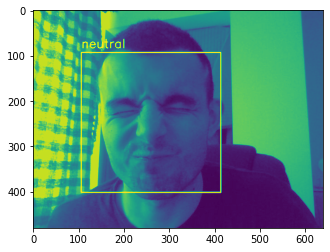

In [57]:
faceCascade = cv2.CascadeClassifier()
faceCascade.load(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
my_face = cv2.imread(DATA_DIR + '/my_face.jpg')
my_face = cv2.cvtColor(my_face, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(
    my_face,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)
x, y, w, h = faces[0]
face = my_face[y: y+h, x: x+w]
face = cv2.resize(face, (48,48))
plt.imshow(face)
face = np.expand_dims(face, axis=0)
face = np.expand_dims(face, axis=-1)
predictions = m.predict(face/255)
pred = np.argmax(predictions)
image = cv2.rectangle(my_face, (x, y), (x + w, y + h), (255,255,255), 2)
cv2.putText(image, possible_emotions[pred], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
plt.imshow(image)
predictions * 100

In [ ]:
plot_face_with_label(image, faces[0], FER_labels[pred])
print(my_face.shape)

print(face.shape)
plt.imshow(face)

In [ ]:
pred = np.argmax(predictions)
predictions * 100

In [ ]:
FER_labels[pred]

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(48, 48, 1),
    classifier_activation="softmax",
)

In [5]:
history = {'accuracy': np.random.randn(10), 'val_accuracy': np.random.randn(10),
'loss': np.random.randn(10), 'val_loss':np.random.randn(10)}

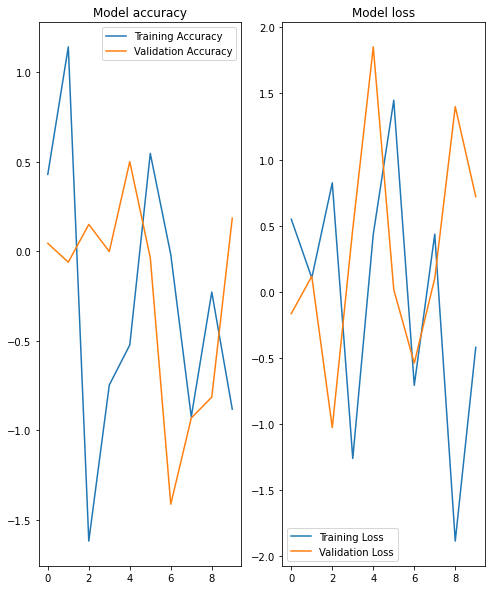

In [6]:
plot_model_history(range(10), history)

In [6]:
my_face = cv2.imread(DATA_DIR + '/my_face.jpg')
my_face = cv2.cvtColor(my_face, cv2.COLOR_BGR2GRAY)

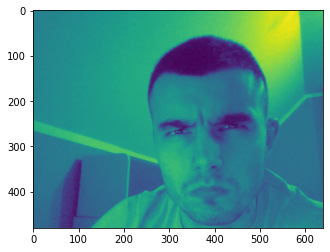

In [8]:
plt.imshow(my_face)

In [12]:
x = random_channel_shift(my_face, 0.2)

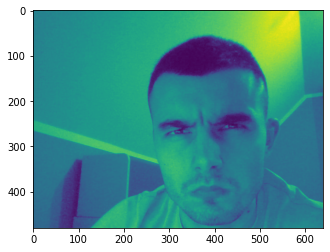

In [14]:
plt.imshow(x)

In [20]:
x_train_FER.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'